In [17]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [21]:
# Define loss functions manually when loading the model
custom_objects = {
    "mse": tf.keras.losses.MeanSquaredError(),
    "categorical_crossentropy": tf.keras.losses.CategoricalCrossentropy()
}

In [25]:
model = tf.keras.models.load_model(filepath='D:/learning_desk/bosch_assignment_bdd_100k/models/ssd_mobilenet_v2_bdd.h5', custom_objects=custom_objects)

In [27]:
CLASS_NAMES = ["traffic light", "traffic sign", "car", "person", "bike", "bus", "truck", "rider", "train", "motor"]  

preprocess the image

In [33]:
def preprocess_image(image_path):
    """
    This function Load and preprocess an image for evaluation.

    Arg:
    image_path: evalution image path 

    Return:
    It returns original image, processed image and oroginal image height and width
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_height, orig_width = image.shape[:2]
    
    # Resize to match model input
    image_resized = cv2.resize(image, (300, 300))
    image_resized = image_resized.astype("float32") / 255.0  # Normalize
    image_resized = np.expand_dims(image_resized, axis=0)  # Add batch dimension

    return image, image_resized, orig_width, orig_height

draw predictions

In [122]:
def draw_predictions(image, boxes, labels):
    """
    Thsi function draw bounding boxes and labels on the image.
    
    Args:
    Image: Image required to draw bounding boxes
    Boxes: Required cocordiinates for the bounding boxes
    labels: Ground truth labels

    Return:
    It returns an image with bounding boxes and labels.
    
    """
    height, width, _ = image.shape

    if len(boxes) == 0:
        print("No bounding boxes to draw!")
        return image

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])  # Convert to integers
        
        class_name = labels[i] if i < len(labels) else "Unknown"
        
        #Ensure y1 - 10 is not negative (Fix OpenCV error)
        text_y = max(y1 - 10, 10)

        #Draw bounding box in RED with thicker lines
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 4)

        #Draw class label with black background and white text
        cv2.putText(image, class_name, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

    return image

compute IoU

In [44]:
def compute_iou(box1, box2):
    """
    This function compute Intersection over Union (IoU) between two bounding boxes.
    
    Args:
    box1: coordinate for the x1 box
    box2: coordinate for the x1 box

    Return:
    It returns 'IoU'
    """
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2

    # Compute intersection
    inter_x1 = max(x1, x1_gt)
    inter_y1 = max(y1, y1_gt)
    inter_x2 = min(x2, x2_gt)
    inter_y2 = min(y2, y2_gt)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    
    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / (union_area + 1e-6)  # Avoid division by zero
    return iou

In [58]:
def get_ground_truth_data(image_name, label_file="D:/learning_desk/bosch_assignment_bdd_100k/data/bdd100k/labels/bdd100k_labels_images_val.json"):
    """
    Extract ground truth bounding boxes and class labels for a given image from the BDD100K label file.
    
    Args:
        image_name (str): The filename of the image to search for in the JSON.
        label_file (str): Path to the BDD100K validation label JSON file.
    
    Returns:
        list: List of bounding boxes [[x1, y1, x2, y2], ...]
        list: List of class labels corresponding to each bounding box
    """
    with open(label_file, "r") as f:
        data = json.load(f)

    gt_boxes = []
    gt_labels = []

    for entry in data:
        if entry["name"] == image_name:
            for item in entry["labels"]:
                if "box2d" in item:  # Ensure the object has a bounding box
                    x1, y1 = item["box2d"]["x1"], item["box2d"]["y1"]
                    x2, y2 = item["box2d"]["x2"], item["box2d"]["y2"]
                    gt_boxes.append([x1, y1, x2, y2])
                    gt_labels.append(item["category"])
            break  # Stop searching after finding the correct image

    return gt_boxes, gt_labels


In [66]:
# Load Image for Evaluation
image_path = "D:/learning_desk/bosch_assignment_bdd_100k/data/bdd100k/images/val/b1cebfb7-284f5117.jpg"
image_name = os.path.basename(image_path)  # Extract filename from path

In [68]:
#Get Ground Truth Data
gt_boxes, gt_labels = get_ground_truth_data(image_name)

In [72]:
original_image, input_image, orig_width, orig_height = preprocess_image(image_path)

In [74]:
predictions = model.predict(input_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [118]:
# Unpack Model Predictions
predicted_boxes = predictions[0].reshape(-1, 4)  # Bounding box predictions (x1, y1, x2, y2)
predicted_classes = np.argmax(predictions[1].reshape(-1, len(CLASS_NAMES)), axis=-1)  # Predicted class indices
predicted_labels = [CLASS_NAMES[idx] for idx in predicted_classes]  # Convert indices to class names

#Remove NaN values and replace with 0
predicted_boxes = np.nan_to_num(predicted_boxes, nan=0.0, posinf=orig_width, neginf=0.0)

#Rescale Bounding Boxes to Original Image Size & Convert to Integers
predicted_boxes[:, [0, 2]] *= orig_width  # Scale x1, x2
predicted_boxes[:, [1, 3]] *= orig_height  # Scale y1, y2

#Ensure all values are within image bounds
predicted_boxes[:, [0, 2]] = np.clip(predicted_boxes[:, [0, 2]], 0, orig_width)
predicted_boxes[:, [1, 3]] = np.clip(predicted_boxes[:, [1, 3]], 0, orig_height)

#Convert to integers
predicted_boxes = np.array(predicted_boxes, dtype=np.int32)

#Compute IoU Only If Ground Truth Exists
ious = []
if len(gt_boxes) > 0:
    for pred_box in predicted_boxes:
        best_iou = 0
        for gt_box in gt_boxes:
            iou = compute_iou(pred_box, gt_box)
            best_iou = max(best_iou, iou)
        ious.append(best_iou)

#Compute Average IoU Safely
average_iou = np.mean(ious) if ious else 0
print(f"Average IoU: {average_iou:.4f}")

Average IoU: 0.0000


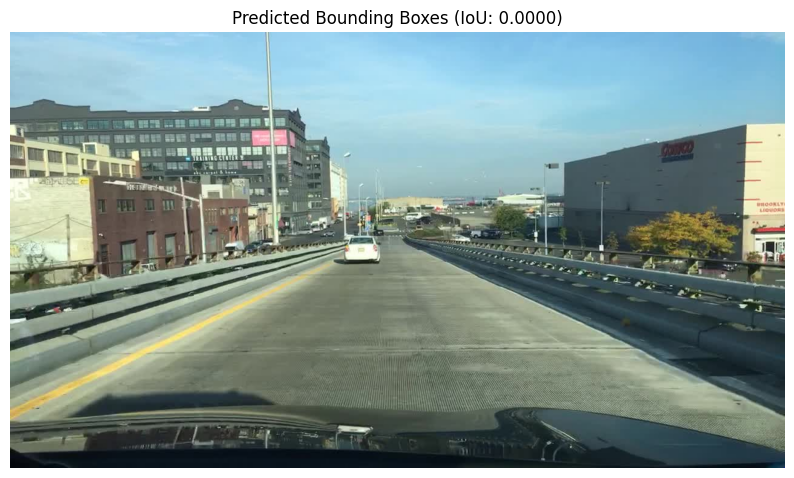

In [124]:
image_with_predictions = draw_predictions(original_image.copy(), predicted_boxes, predicted_labels)

#Display Image with Predictions
plt.figure(figsize=(10, 6))
plt.imshow(image_with_predictions)
plt.axis("off")
plt.title(f"Predicted Bounding Boxes (IoU: {average_iou:.4f})")
plt.show()